In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

import time  

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.pipeline import make_pipeline 

from PIL import Image 


from bs4 import BeautifulSoup 
from selenium import webdriver  
import networkx as nx 

import pickle

import warnings 
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
phishing_data1 = pd.read_csv('C:/Users/krish/Desktop/newinfosec/infourldata.csv',usecols=['Domain','Label'],encoding='latin1', error_bad_lines=False)
phishing_data1.columns = ['Domain','Label']

In [4]:
for l in range(len(phishing_data1.Label)):
    if phishing_data1.Label.loc[l] == '1.0':
        phishing_data1.Label.loc[l] = 'bad'
    else:
        phishing_data1.Label.loc[l] = 'good'

In [3]:
frames = [phishing_data1]
phishing_urls = pd.concat(frames)

In [4]:
#saving dataset
phishing_urls.to_csv(r'C:/Users/krish/Desktop/newinfosec/5.urldata.csv', index = False)

In [5]:
phish_data = pd.read_csv('C:/Users/krish/Desktop/newinfosec/5.urldata.csv')

In [6]:
phish_data.head()

,Domain,Label
0,graphicriver.net,0
1,ecnavi.jp,0
2,hubpages.com,0
3,extratorrent.cc,0
4,icicibank.com,0


In [7]:
phish_data.tail()

,Domain,Label
9995,wvk12-my.sharepoint.com,1
9996,adplife.com,1
9997,kurortnoye.com.ua,1
9998,norcaltc-my.sharepoint.com,1
9999,sieck-kuehlsysteme.de,1


In [8]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Domain  10000 non-null  object
 1   Label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [9]:
phish_data.isnull().sum() # there is no missing values

Domain    0
Label     0
dtype: int64

In [10]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

<AxesSubplot:ylabel='Label'>

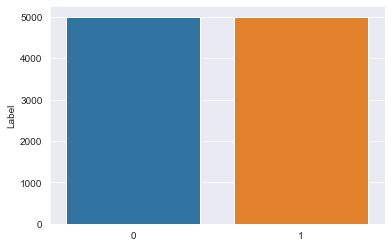

In [11]:
#visualizing target_col
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

In [12]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [13]:
phish_data.Domain[0]

'graphicriver.net'

In [14]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.Domain[0]) # using first row

['graphicriver', 'net']

In [15]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.Domain.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 0.01677829999999858 sec


In [16]:
phish_data.sample(5)

,Domain,Label,text_tokenized
1520,udn.com,0,"[udn, com]"
8567,forms.office.com,1,"[forms, office, com]"
8299,sicurezzawebprepagata.com,1,"[sicurezzawebprepagata, com]"
3856,quizlet.com,0,"[quizlet, com]"
2294,xhamster.com,0,"[xhamster, com]"


In [17]:
stemmer = SnowballStemmer("english") # choose a language

In [18]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 0.24152080000000353 sec


In [19]:
phish_data.sample(5)

,Domain,Label,text_tokenized,text_stemmed
8908,ukcare.in,1,"[ukcare, in]","[ukcar, in]"
3745,twitter.com,0,"[twitter, com]","[twitter, com]"
2962,auto.ru,0,"[auto, ru]","[auto, ru]"
7941,csgoluntan.com,1,"[csgoluntan, com]","[csgoluntan, com]"
3480,techcrunch.com,0,"[techcrunch, com]","[techcrunch, com]"


In [20]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.006140899999991234 sec


In [21]:
phish_data.sample(5)

,Domain,Label,text_tokenized,text_stemmed,text_sent
6034,movebetterrunbetter.com,1,"[movebetterrunbetter, com]","[movebetterrunbett, com]",movebetterrunbett com
3085,torrentdn.com,0,"[torrentdn, com]","[torrentdn, com]",torrentdn com
5545,ruasepicas.pt,1,"[ruasepicas, pt]","[ruasepica, pt]",ruasepica pt
4043,mic.com,0,"[mic, com]","[mic, com]",mic com
967,twitter.com,0,"[twitter, com]","[twitter, com]",twitter com


### Visualization 
**1. Visualize some important keys using word cloud**

In [23]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == '1']
good_sites = phish_data[phish_data.Label == '0']

In [24]:
bad_sites.head()

,Domain,Label,text_tokenized,text_stemmed,text_sent


In [25]:
good_sites.head()

,Domain,Label,text_tokenized,text_stemmed,text_sent


* create a function to visualize the important keys from url 

In [26]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [27]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [28]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [29]:
driver = webdriver.Chrome(executable_path= 'C:\\Users\\krish\\Desktop\\webdriver\\chromedriver.exe')

In [30]:
list_urls = ['https://www.foto-yama.kiev.ua/wp-content/uploads/2012/07/index.htm'] #here i take phishing sites 
links_with_text = []

In [31]:
for url in list_urls:
    driver.get(url)
    soup = BeautifulSoup(driver.page_source,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

In [32]:
df = pd.DataFrame(links_with_text, columns=["from", "to"])

In [33]:
df.head()

,from,to
0,https://www.foto-yama.kiev.ua/wp-content/uploa...,#content
1,https://www.foto-yama.kiev.ua/wp-content/uploa...,/
2,https://www.foto-yama.kiev.ua/wp-content/uploa...,/
3,https://www.foto-yama.kiev.ua/wp-content/uploa...,/?cat=9
4,https://www.foto-yama.kiev.ua/wp-content/uploa...,/?cat=18


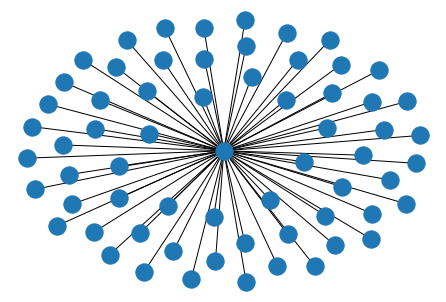

In [34]:
GA = nx.from_pandas_edgelist(df, source="from", target="to")
nx.draw(GA, with_labels=False)

### Creating Model

In [35]:
#create cv object
cv = CountVectorizer()

In [ ]:
#help(CountVectorizer())

In [36]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [37]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### * Spliting the data 

In [38]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

In [39]:
# create lr object
lr = LogisticRegression()

In [40]:
lr.fit(trainX,trainY)

LogisticRegression()

In [41]:
lr.score(testX,testY)

0.976

In [42]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9872
Testing Accuracy : 0.976

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.99      0.98      1239
        Good       0.99      0.97      0.98      1261

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500


CONFUSION MATRIX


<AxesSubplot:>

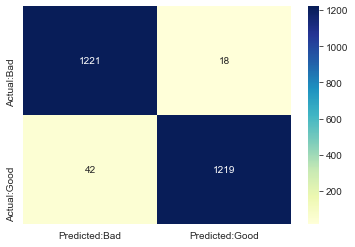

In [43]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

<AxesSubplot:ylabel='Accuracy'>

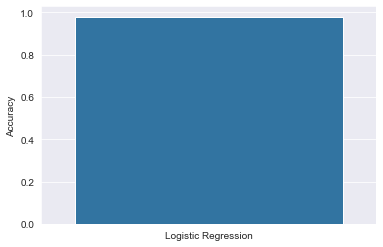

In [44]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

In [45]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression()) 

In [46]:
trainX, testX, trainY, testY = train_test_split(phish_data.Domain, phish_data.Label)

In [47]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [48]:
pipeline_ls.score(testX,testY) 

0.9788

Training Accuracy : 0.9877333333333334
Testing Accuracy : 0.9788

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.99      0.98      1231
        Good       0.99      0.97      0.98      1269

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500


CONFUSION MATRIX


<AxesSubplot:>

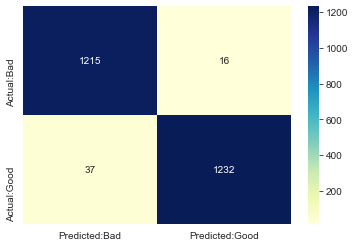

In [49]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [50]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [51]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9788


In [52]:
predict_bad = ['https://www.foto-yama.kiev.ua/wp-content/uploads/2012/07/index.htm']
predict_good = ['hubpages.com',]
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

[1]
******************************
[0]
